Unconfined, 1 layer, transient structured grid model with a pumping well and an observation well #newton under-relaxation

In [1]:
import flopy
import pathlib as pl
import glob

from flopy.utils import GridIntersect, Raster, binaryfile
from shapely.geometry import Polygon, Point
from rasterio.transform import from_origin

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import geopandas as gpd
import rasterio as rio
import scipy.interpolate
import os
import flopy.utils.binaryfile as bf

In [2]:
flopy.__version__

'3.8.0'

Load files of interpolated properties 

In [3]:
top_data = np.loadtxt('../source_data_props/interpolated_properties/top_elev_int.txt', delimiter=' ')
bot_data = np.loadtxt('../source_data_props/interpolated_properties/bottom_elev_int.txt', delimiter=' ')
K_data = np.loadtxt('../source_data_props/interpolated_properties/K_cond_int.txt', delimiter=' ')
evt_data = np.loadtxt('../source_data_props/interpolated_properties/evt_surf_elev_int.txt', delimiter=' ')
rch_data = np.loadtxt('../source_data_props/interpolated_properties/rch_int.txt', delimiter=' ')

In [4]:
heads_data = pd.read_csv('../source_data_props/interpolated_properties/heads_int.csv')

Make simulation and model object with relevant packages

In [5]:
sim = flopy.mf6.MFSimulation(
    sim_name='rvt_ssma-2', exe_name="mf6", version="mf6", sim_ws="."
) 

In [6]:
tdis = flopy.mf6.modflow.mftdis.ModflowTdis(
    sim,
    pname="tdis",
    time_units="DAYS",
    nper=3,
    perioddata=[
        (1.00, 1,  1.2),
        (0.161, 10, 1.2), #updated
        (0.0019, 10, 1.2) #updated
    ]
)

In [7]:
ims = flopy.mf6.ModflowIms(sim, print_option='ALL', pname='IMS', complexity='MODERATE', under_relaxation = 'DBD', outer_dvclose=1e-3, inner_dvclose=1e-6)

In [8]:
m = flopy.mf6.ModflowGwf(sim, modelname='rvt_ssma-2', model_nam_file='rvt_ssma-2.nam', save_flows=True, newtonoptions=['under_relaxation'])

In [9]:
xlen = 300.0
ylen = 300.0
nrow = 200
ncol = 200

In [10]:
dis = flopy.mf6.ModflowGwfdis(
    m,
    length_units='FEET',
    xorigin=593583.491,
    yorigin=846116.344,
    nlay=1,
    nrow=nrow,
    ncol=ncol,
    delr = np.full(ncol, xlen / ncol, dtype=float),
    delc = np.full(nrow, ylen / nrow, dtype=float), 
    top=top_data,
    botm=bot_data,
    pname='DIS'
)

In [11]:
ic = flopy.mf6.ModflowGwfic(m, pname="IC", strt=top_data)

In [12]:
npf = flopy.mf6.ModflowGwfnpf(m, icelltype=1, k=K_data*0.25, pname = "NPF", save_flows=True)

In [13]:
chd_rec = {0: [], 1: [], 2: []}

for _, row in heads_data.iterrows():
    for i in range(3): #three stress periods
        node = (0, int(row['row']), int(row['col']), row[f'h_t1s{i+1}']) #tuple
        if node not in chd_rec[i]: #removes duplicates
            chd_rec[i].append(node)

In [14]:
chd = flopy.mf6.ModflowGwfchd(
    model=m,
    maxbound=len(chd_rec),
    stress_period_data=chd_rec,
    save_flows=True,
)

In [15]:
rch_rec = {0: [], 1: [], 2: []}   

for row in range(nrow):
    for col in range(ncol):
        rch_rec[0].append((0, row, col, rch_data[row, col]))
        rch_rec[1].append((0, row, col, rch_data[row, col]))
        rch_rec[2].append((0, row, col, rch_data[row, col]))

In [16]:
rch = flopy.mf6.ModflowGwfrch(
    m,
    maxbound=len(rch_rec),  
    stress_period_data=rch_rec  
)

In [17]:
evt_rec = {0: [], 1: [], 2: []}  

for row in range(nrow):
    for col in range(ncol):
        evt_surface = evt_data[row, col].astype(np.float32)
        evt_rec[0].append((0, row, col, evt_surface, 0.007, 8.0))  #layer, row, col, surface, rate, depth
        evt_rec[1].append((0, row, col, evt_surface, 0.007, 8.0))
        evt_rec[2].append((0, row, col, evt_surface, 0.007, 8.0))

In [18]:
evt = flopy.mf6.ModflowGwfevt(
    m,
    pname="evt",
    maxbound=len(evt_rec),  
    stress_period_data=evt_rec  
)

In [19]:
sto = flopy.mf6.ModflowGwfsto(m, pname = "STO", iconvert = 3, ss = 1e-07, sy = 0.00753,steady_state={0: True}, transient={1: True},)  #the calibrated values 

In [20]:
stress_period_data_wel = { # zero-based indexing
    0: [((0, 101, 98), 0)],
    1: [((0, 101, 98), -63.5)],  
    2: [((0, 101, 98), 0)],
}

In [21]:
wel = flopy.mf6.ModflowGwfwel(m, pname = "WEL", stress_period_data=stress_period_data_wel,)

In [22]:
obsdict = {}
obslist = [["w1006", "head", (0, 100, 100)]]
obsdict["w1006-2.csv"] = obslist
obs = flopy.mf6.ModflowUtlobs(m, print_input=False, continuous=obsdict)

In [23]:
headfile = "rvt_ssma-2.hds"
head_filerecord = [headfile]
budgetfile = "rvt_ssma-2.cbb"
budget_filerecord = [budgetfile]
saverecord = [("HEAD", "ALL"), ("BUDGET", "LAST")]
printrecord = [("HEAD", "LAST")]
oc = flopy.mf6.ModflowGwfoc(
    m,
    saverecord=saverecord,
    head_filerecord=head_filerecord,
    budget_filerecord=budget_filerecord,
    printrecord=printrecord,
)

In [24]:
sim.write_simulation()

writing simulation...
  writing simulation name file...
  writing simulation tdis package...
  writing solution package ims...
  writing model rvt_ssma-2...
    writing model name file...
    writing package dis...
    writing package ic...
    writing package npf...
    writing package chd_0...
INFORMATION: maxbound in ('gwf6', 'chd', 'dimensions') changed to 796 based on size of stress_period_data
    writing package rch_0...
INFORMATION: maxbound in ('gwf6', 'rch', 'dimensions') changed to 40000 based on size of stress_period_data
    writing package evt...
INFORMATION: maxbound in ('gwf6', 'evt', 'dimensions') changed to 40000 based on size of stress_period_data
    writing package sto...
    writing package wel...
INFORMATION: maxbound in ('gwf6', 'wel', 'dimensions') changed to 1 based on size of stress_period_data
    writing package obs_0...
    writing package oc...


In [25]:
success, buff = sim.run_simulation(
    silent=None,
    pause=False,
    report=False,
    processors=None,
    normal_msg='normal termination',
    use_async=False,
    cargs=None,
    custom_print=None,
)

FloPy is using the following executable to run the model: mf6.exe
                                   MODFLOW 6
                U.S. GEOLOGICAL SURVEY MODULAR HYDROLOGIC MODEL
                            VERSION 6.5.0 05/23/2024

   MODFLOW 6 compiled May 23 2024 18:06:57 with Intel(R) Fortran Intel(R) 64
   Compiler Classic for applications running on Intel(R) 64, Version 2021.7.0
                             Build 20220726_000000

This software has been approved for release by the U.S. Geological 
Survey (USGS). Although the software has been subjected to rigorous 
review, the USGS reserves the right to update the software as needed 
pursuant to further analysis and review. No warranty, expressed or 
implied, is made by the USGS or the U.S. Government as to the 
functionality of the software and related material nor shall the 
fact of release constitute any such warranty. Furthermore, the 
software is released on condition that neither the USGS nor the U.S. 
Government shall be held l

In [26]:
hobj = flopy.utils.HeadFile('rvt_ssma-2.hds', model=m)
hobj.headers

,kstp,kper,pertim,totim,text,ncol,nrow,ilay
52,1,1,1.000000,1.000000,HEAD,200,200,1
320104,1,2,0.006202,1.006202,HEAD,200,200,1
640156,2,2,0.013645,1.013645,HEAD,200,200,1
960208,3,2,0.022576,1.022576,HEAD,200,200,1
1280260,4,2,0.033293,1.033293,HEAD,200,200,1
1600312,5,2,0.046154,1.046154,HEAD,200,200,1
1920364,6,2,0.061587,1.061587,HEAD,200,200,1
2240416,7,2,0.080107,1.080107,HEAD,200,200,1
2560468,8,2,0.102330,1.102330,HEAD,200,200,1
2880520,9,2,0.128998,1.128998,HEAD,200,200,1


Plotting head distribution and well locations at the modelgrid

In [27]:
head_values = hobj.get_data(mflay=0)
head_array = np.array(head_values)
head_array = head_array.reshape(-1, 1)
np.savetxt("rvt_ssma-2_hds.txt", head_array, delimiter=",", newline="\n")

In [28]:
well_locations = [
    Point(593730.641, 846267.604),
    Point(593729.391, 846264.894),
    Point(593728.141, 846262.314),
    Point(593728.871, 846256.484),
    Point(593730.851, 846260.844),
    Point(593732.221, 846263.654),
    Point(593733.491, 846266.344),
    Point(593735.321, 846270.994),
    Point(593739.921, 846268.894),
    Point(593737.941, 846264.394),
    Point(593736.731, 846261.664),
    Point(593735.251, 846258.954),
    Point(593733.221, 846254.464)
]

head_data = {
    "TS1_SP1": hobj.get_data(kstpkper=(0, 0)),
    "TS1_SP2": hobj.get_data(kstpkper=(0, 1)),
    "TS1_SP3": hobj.get_data(kstpkper=(0, 2))
}

In [29]:
def plot_head(head_name, head_data, well_locations, title_fontsize=8, tick_fontsize=8, cbar_fontsize=8, contour_fontsize=8):
    fig, ax = plt.subplots(figsize=(5, 5))
    ax.set_title(f"Head - {head_name}", fontsize=title_fontsize)

    # Create map view
    pmv = flopy.plot.PlotMapView(model=m, ax=ax)

    # Plot the head data with a color array
    img = pmv.plot_array(head_data, alpha=0.5, cmap='YlGnBu', edgecolor='none')

    # Colorbar settings
    cbar = plt.colorbar(img, ax=ax, label='Head (ft)')
    cbar.ax.tick_params(labelsize=cbar_fontsize)
    cbar.set_label('Head (ft)', fontsize=cbar_fontsize)

    # Contour settings
    levels = np.arange(4500, 5000, 0.05)
    contour = pmv.contour_array(head_data, levels=levels, colors='black', linewidths=0.5, linestyles='None')
    plt.clabel(contour, fontsize=contour_fontsize, fmt='%.2f')

    # Plot well locations
    well_x = [well.x for well in well_locations]
    well_y = [well.y for well in well_locations]
    ax.scatter(well_x, well_y, color='red', label='Wells', zorder=5, s=2)

    # Axis settings
    ax.tick_params(axis='both', labelsize=tick_fontsize)
    plt.xticks(rotation=45)

    # Save the plot
    plt.tight_layout()
    plt.savefig(f'img/heads_mf6_{head_name}.png', dpi=300)
    plt.close()

# Loop through head data and plot
for head_name, head_array in head_data.items():
    plot_head(head_name, head_array, well_locations)

Plotting heads at observation well 1006

In [30]:
df1 = pd.read_csv('w1006-2.csv')

In [31]:
df1.columns.tolist()

['time', 'W1006']

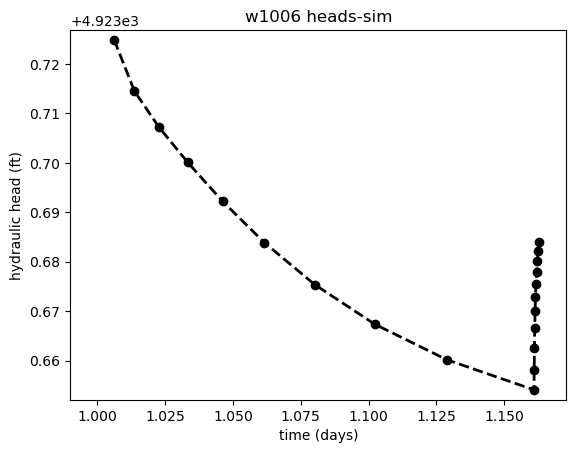

<Figure size 1000x600 with 0 Axes>

In [32]:
x1 = df1['time'][1:]
y1 = df1['W1006'][1:]

plt.plot(x1, y1, color='black', marker='o', linestyle='dashed', linewidth=2, markersize=6)

plt.xlim(0.99, max(x1)+0.01) #have to count minus 1 day since the x axis starting from day 1
plt.ylim(min(y1)-0.002, max(y1)+0.002)

plt.xlabel('time (days)')
plt.ylabel('hydraulic head (ft)')
plt.title('w1006 heads-sim')

plt.savefig('./img/W1006_heads_unconfined_1L.png', dpi=300)
plt.figure(figsize=(10, 6))
plt.show()

Plotting drawdown at observation well 1006

In [33]:
first_head = df1['W1006'][1]
df1['Drawdown'] = df1['W1006'] - first_head

In [34]:
first_head

4923.724846245835

In [35]:
first_time = df1['time'][1]
df1['time_hours'] = (df1['time']-first_time)*24

In [36]:
first_time

1.006202163858

In [37]:
df1.to_csv('drawdown_hours_w1006_sim_unconf_1L.csv', index=False)

In [38]:
df2 = pd.read_csv('drawdown_hours_w1006_sim_unconf_1L.csv')

In [39]:
df2.columns.tolist()

['time', 'W1006', 'Drawdown', 'time_hours']

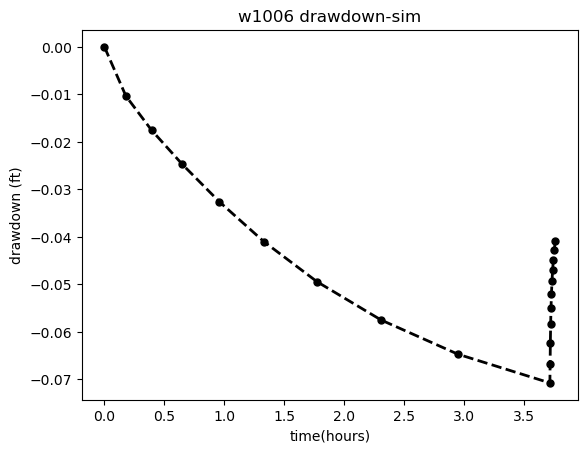

<Figure size 1000x600 with 0 Axes>

In [46]:
x2 = df2['time_hours'][1:]  
y2 = df2['Drawdown'][1:]

plt.plot(x2, y2, color='black', marker='o', linestyle='dashed', linewidth=2, markersize=5)

plt.xlabel('time(hours)')
plt.ylabel('drawdown (ft)')
plt.title('w1006 drawdown-sim')

plt.savefig('./img/W1006_drawdown_sim_unconf_1L.png', dpi=300)
plt.figure(figsize=(10, 6))
plt.show()

Plot field observational data

In [41]:
df3 = pd.read_csv('../source_data_props/observation_data/pump_test_data_w1006.csv')

In [42]:
df3.columns.tolist()

['Hours Past Since Pumping',
 'Head w1006 (cm)',
 'dd w1006 (cm)',
 'dd w1006 (ft)']

In [43]:
x3 = df3['Hours Past Since Pumping'][:2868]
y3 = df3['dd w1006 (ft)'][:2868]

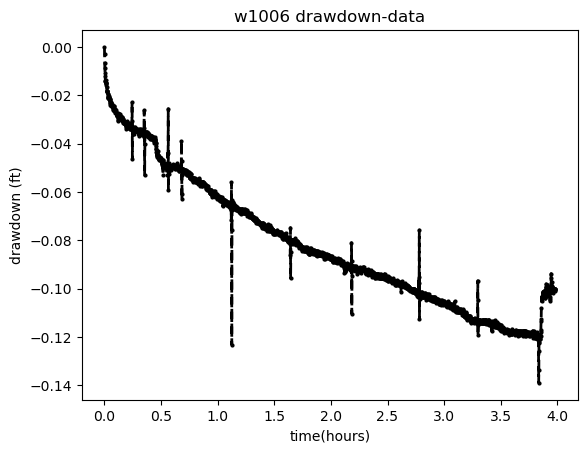

<Figure size 1000x600 with 0 Axes>

In [44]:
plt.plot(x3, y3, color='black', marker='o', linestyle='dashed', linewidth=2, markersize=2)

#plt.xlim(0, max(x))

#ax = plt.gca()
#ax.invert_yaxis()

plt.xlabel('time(hours)')
plt.ylabel('drawdown (ft)')
plt.title('w1006 drawdown-data')

plt.savefig('./img/W1006_drawdown-data.png', dpi=300)
plt.figure(figsize=(10, 6))
plt.show()